## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
import math

Importing and formatting the training data

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set.csv")

In [3]:
# Seperating variables
# The outcomes
tornado_outcome = tor_df.iloc[:, [0]]


# Make sure variable is right
list(tornado_outcome)

['DAMAGE_PROPERTY']

In [4]:
# The predictors
tornado_predictors = tor_df.loc[:, ["DURATION_SECONDS",
                                  "TOR_LENGTH",
                                  "TOR_WIDTH",
                                  "YEAR",
                                  "MULTI_VORT_IND",
                                  "TOR_AREA",
                                  "DAY_OF_YEAR",
                                  "MONTH",
                                  "TIME"]]


# Make sure the variables are right
list(tornado_predictors)

['DURATION_SECONDS',
 'TOR_LENGTH',
 'TOR_WIDTH',
 'YEAR',
 'MULTI_VORT_IND',
 'TOR_AREA',
 'DAY_OF_YEAR',
 'MONTH',
 'TIME']

In [5]:
# Make the outcomes into a numpy array
outcome_array = tornado_outcome.values

# Makes that numpy array into a torch Tensor
outcome_Tensor = torch.from_numpy(outcome_array)


# Make the predictors into a numpy array
predictors_array = tornado_predictors.values

# Make that numpy array into a torch Tensor
predictors_Tensor = torch.from_numpy(predictors_array)


# Convert those DoubleTensors to FloatTensors
# Changing outcomes from a DoubleTensor to a FloatTensor
outcome_Tensor = outcome_Tensor.float()

# Changing predictors too
predictors_Tensor = predictors_Tensor.float()

Now the cross-validation data

In [6]:
# Import cross-validation data
cv_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set.csv")


# Get the outcomes
cv_outcome = cv_df.iloc[:, [0]]

# Convert the pandas column to a ndarray and then into a FloatTensor
cv_outcome_Tensor = torch.from_numpy(cv_outcome.values).float()


# Make sure the variable is right
list(cv_outcome)

['DAMAGE_PROPERTY']

In [7]:
# Get the validation set predictors
cv_predictors = cv_df.loc[:, ["DURATION_SECONDS",
                              "TOR_LENGTH",
                              "TOR_WIDTH",
                              "YEAR",
                              "MULTI_VORT_IND",
                              "TOR_AREA",
                              "DAY_OF_YEAR",
                              "MONTH",
                              "TIME"]]

# Make the validation set predictors into a numpy array
cv_predictors_Tensor = torch.from_numpy(cv_predictors.values).float()


# Make sure the variables are right
list(cv_predictors)

['DURATION_SECONDS',
 'TOR_LENGTH',
 'TOR_WIDTH',
 'YEAR',
 'MULTI_VORT_IND',
 'TOR_AREA',
 'DAY_OF_YEAR',
 'MONTH',
 'TIME']

Now the test set data

In [8]:
# Import the test set data
test_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_test_set.csv")


# Get the outcomes
test_outcome = test_df.iloc[:, [0]]

# Convert the pandas column to a ndarray and then into a FloatTensor
test_outcome_Tensor = torch.from_numpy(test_outcome.values).float()


# Make sure the variable is right
list(test_outcome)

['DAMAGE_PROPERTY']

In [9]:
# Get the test set predictors
test_predictors = test_df.loc[:, ["DURATION_SECONDS",
                                  "TOR_LENGTH",
                                  "TOR_WIDTH",
                                  "YEAR",
                                  "MULTI_VORT_IND",
                                  "TOR_AREA",
                                  "DAY_OF_YEAR",
                                  "MONTH",
                                  "TIME"]]

# Make the test set predictors into a numpy array
test_predictors_Tensor = torch.from_numpy(test_predictors.values).float()


# Make sure the variables are right
list(test_predictors)

['DURATION_SECONDS',
 'TOR_LENGTH',
 'TOR_WIDTH',
 'YEAR',
 'MULTI_VORT_IND',
 'TOR_AREA',
 'DAY_OF_YEAR',
 'MONTH',
 'TIME']

## 1. One-Hidden-Layer Neural Network

Define the model architecture

In [10]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(9, 6)
        self.fc2 = torch.nn.Linear(6, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)


# Make it
model = Net()

Define the loss function

In [11]:
loss_fn = torch.nn.MSELoss(size_average = False)

Defining a function to setup and train the models. It will also produce a loss versus iteration plot

In [12]:
def train_neural_net(model, train_outcomes, train_inputs,
                     cv_outcomes, cv_inputs):
    
    # This function will train the neural network and produce a loss versus iteration plot
    # model = the model architecture
    # train_outcomes = the right answers
    # train_inputs = what we're using to get to the right answers
    # cv_outcomes = the right answers of the new data
    # cv_inputs = what we're using to get the new right answers
    
    
    # Make the outcomes into a Torch Variable
    outcome_Variable = Variable(train_outcomes)
    
    # Make the cv outcomes into a Torch Variable
    cv_outcome_Variable = Variable(cv_outcomes,
                                   requires_grad = False)
    
    # Make the predictors into a Torch Variable
    predictors_Variable = Variable(train_inputs,
                                   requires_grad = False)
    
    # Make the cv predictors into a Torch Variable
    cv_predictors_Variable = Variable(cv_inputs,
                                      requires_grad = False)
    
    
    # Make an empty list to add to for each iteration
    current_loss_value = []
    
    # For the cv too
    current_cv_loss_value = []
    
    
    # Set the optimizer
    optimizer = torch.optim.Adagrad(model.parameters(), lr = 1e-2)
    
    
    # Train the neural network
    for t in range(15000):
        
        # Get the current predictions
        current_pred = model(predictors_Variable)
        cv_pred = model(cv_predictors_Variable)
        
        # Compute current loss and and append that to the empty list
        current_loss = loss_fn(current_pred, outcome_Variable)
        current_loss_value.append(current_loss.data[0])
        
        current_cv_loss = loss_fn(cv_pred, cv_outcome_Variable)
        current_cv_loss_value.append(current_cv_loss.data[0])
        
        # Zero the gradients before backwards pass
        optimizer.zero_grad()
        
        # Backwards pass
        current_loss.backward()
        
        # Update model parameters
        optimizer.step()
    
    
    # Get iterations as a list for x-axis of plot
    iterations = list(range(0, 15000))
    
    
    # Convert total square error to mean square error
    mse = (np.asarray(current_loss_value) / len(predictors_Variable)).tolist()
    
    # For cv too
    mse_cv = (np.asarray(current_cv_loss_value) / len(cv_predictors_Variable)).tolist()
    
    
    # Plot loss versus iteration
    plt.plot(iterations, mse)
    plt.plot(iterations, mse_cv, "r-")
    plt.xlabel("Iteration")
    plt.ylabel("Loss Value")
    plt.title("How'd the Optimizing Go?")

Train the first model.

The plot will display how well it optimized. The blue line is the data the model was optimized on, while the red line is new (cross-validation) data.

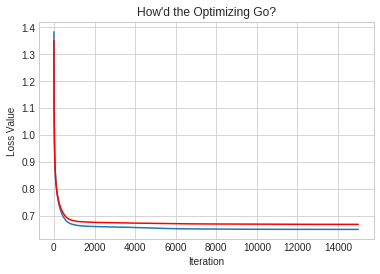

In [13]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

### 1.1 Performance Metrics

We're really interested in how it does on new data, so let's get some metrics of its performance on the new data.

First: Mean squared error (MSE)

In [14]:
def compute_MSE(predictors, observed_outcomes):
    
    # Computes the mean squared error of the model
    # predictors = the variables and values used in prediction
    # observed_outcomes = what the prediction would ideally yield

    
    # Get the validation set predictions
    cv_predictions = model(Variable(predictors, requires_grad = False))
    
    # Get the validation set outcomes
    cv_outcomes = Variable(observed_outcomes)
    
    
    # Get the loss - (total) residual sum of squares
    total_SE = loss_fn(cv_predictions, cv_outcomes)
    
    # Average that to get mean square error
    mean_SE = total_SE / len(predictors)
    return(mean_SE)

In [15]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 0.6672
[torch.FloatTensor of size 1]

In [16]:
def compute_R_squared(predictors, observed_outcomes):
    
    # Computes R-squared of the model
    # predictors = the variables and values used in prediction
    # observed_outcomes = what the prediction would ideally yield
    
    
    # Get the mean of the observed outcomes
    observed_mean = (sum(observed_outcomes) / len(observed_outcomes)).numpy()[0]
    
    # Fill an ndarray with that
    valid_outcomes_mean = np.repeat(observed_mean, len(observed_outcomes))
    
    # Convert that to a Variable
    valid_outcomes_mean = Variable(torch.from_numpy(valid_outcomes_mean))
    
    
    # Compute total sum of squares
    TSS = loss_fn(valid_outcomes_mean, Variable(observed_outcomes))
    
    
    # Compute residual sum of squares
    RSS = loss_fn(model(Variable(predictors)), Variable(observed_outcomes))
    
    
    # Compute R-squared
    R_squared = 1 - (RSS / TSS)
    return(R_squared)

In [17]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)
R_squared

Variable containing:
 0.3240
[torch.FloatTensor of size 1]

### 1.2 Performance Visualization

In log-transformed space, plot predicted values versus observed values for new data

In [18]:
def plot_cross_valid_perf(cv_predictors, cv_obs):
    
    # Plots how well the model performs on new data
    # cv_pred = the values that the model predicts from
    # cv_obs = what the model would ideally predict
    
    
    # Get the predictions
    cv_predictions = model(Variable(cv_predictors, requires_grad = False))
    
    # Convert that to a numpy array
    cv_predictions = cv_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    cv_predictions = (cv_predictions*5.407597 + 7.688844).tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    cv_obs = (cv_obs.numpy()*5.407597 + 7.688844).tolist()
    
    
    # Plot it
    plt.scatter(cv_obs, cv_predictions, facecolors = "none", edgecolors = "k")
    axes = plt.gca()
    axes.set_xlim([-1, 24])
    axes.set_ylim([-1, 24])
    axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)
    axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")
    axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")
    axes.set_title("Model Performance on Cross-Validation Data")
    plt.text(0.5, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))
    plt.text(0.5, 19, "MSE = %s"%(MSE.data.numpy()[0]))

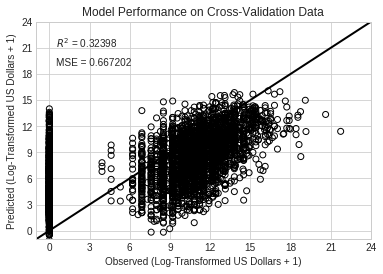

In [19]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

Lastly, let's inspect the first hidden layer's weights

In [20]:
model.fc1.weight

Parameter containing:
-0.1979 -0.1442 -0.1437  0.0360  0.3916  0.4171 -0.0314 -0.0492 -0.6382
-0.1783 -0.1437 -0.1069  0.4613  0.8640 -0.1238 -0.1668 -0.0433 -0.6789
 0.0082 -0.2671 -0.0031  0.1399 -0.8449  0.0616  0.7053 -0.1236 -0.1753
 0.1045 -0.0713 -0.1623  0.0158 -0.1292  0.0841  0.0156 -1.1661 -0.0209
-0.0559  0.1284  0.3098 -0.3691  0.2831  0.5691  0.4379 -0.0264  0.0512
 0.0420 -0.3254  0.0215  0.4010 -0.7095  0.2884 -0.3298 -0.0550 -0.3864
[torch.FloatTensor of size 6x9]

### 1.3 Store Predictions

In [21]:
def obs_as_col(obs_Tens):
    
    # Saves observed outcomes as a pandas column
    # obs_Tens = a Tensor containing observed outcomes
    
    
    # Convert the Tensor to a list
    obs_list = obs_Tens.numpy().tolist()
    
    
    # Make an empty list
    obs_flat_list = []
    
    
    # Unnest the Tensor-list into the empty list
    for sublist in obs_list:
        for val in sublist:
            obs_flat_list.append(val)
    
    
    # Turn that list into a pandas DataFrame
    obs_pd_column = pd.DataFrame(obs_flat_list)
    return(obs_pd_column)

In [22]:
cv_stored = obs_as_col(cv_outcome_Tensor)

cv_stored.columns = ["observed"]

In [23]:
test_stored = obs_as_col(test_outcome_Tensor)

test_stored.columns = ["observed"]

In [24]:
def add_to_stored(new_col_name, pred_Tens, already_made):
    
    model_pred = model(Variable(pred_Tens)).resize(len(pred_Tens))
    
    model_pred = model_pred.data.numpy()
    
    already_made[new_col_name] = pd.Series(model_pred, index = already_made.index)

In [25]:
add_to_stored("cv_pred_1", cv_predictors_Tensor, cv_stored)

add_to_stored("test_pred_1", test_predictors_Tensor, test_stored)

## 2. Two-Hidden-Layer Neural Network

In [26]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(9, 6)
        self.fc2 = torch.nn.Linear(6, 4)
        self.fc3 = torch.nn.Linear(4, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return(x)


# Make it
model = Net()

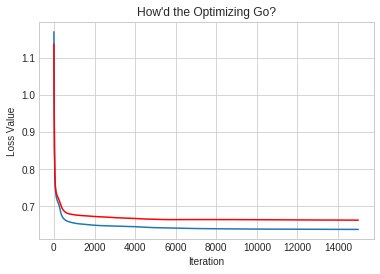

In [27]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

### 2.1 Performance Metrics

In [28]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 0.6629
[torch.FloatTensor of size 1]

In [29]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)
R_squared

Variable containing:
 0.3283
[torch.FloatTensor of size 1]

### 2.2 Performance Visualization

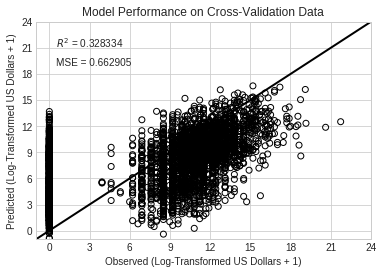

In [30]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [31]:
model.fc1.weight

Parameter containing:
-0.1672  0.0229  0.1734 -0.2106 -0.1290  0.6048 -0.1144  0.1517 -0.4061
-0.2082 -0.3250 -0.4277 -0.1928  0.1018 -0.0630 -0.1023  0.1879  0.1979
-0.0704 -0.3309  0.1937 -0.0772  1.2817 -0.1818  0.4195 -0.3679  0.1706
-0.0820 -0.0606  0.0569  0.4020 -0.1278 -0.0066  0.8341 -0.4968 -0.1556
 0.7780 -0.0798 -0.5629 -0.0670  1.4753  0.2094  0.8390 -0.6906  0.2691
 0.1037  0.4056  0.6452 -0.2366  0.6600 -0.2854  0.1982 -0.1285  0.6037
[torch.FloatTensor of size 6x9]

### 2.3 Store Predictions

In [32]:
add_to_stored("cv_pred_2", cv_predictors_Tensor, cv_stored)

add_to_stored("test_pred_2", test_predictors_Tensor, test_stored)

## 3. Three-Hidden-Layer Neural Network

In [33]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(9, 6)
        self.fc2 = torch.nn.Linear(6, 4)
        self.fc3 = torch.nn.Linear(4, 3)
        self.fc4 = torch.nn.Linear(3, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return(x)


# Make it
model = Net()

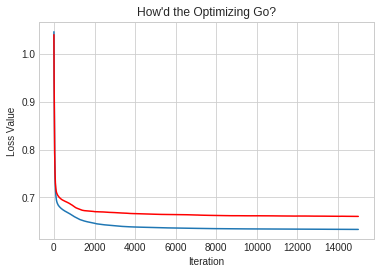

In [34]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

### 3.1 Performance Metrics

In [35]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 0.6605
[torch.FloatTensor of size 1]

In [36]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)
R_squared

Variable containing:
 0.3308
[torch.FloatTensor of size 1]

### 3.2 Performance Visualization

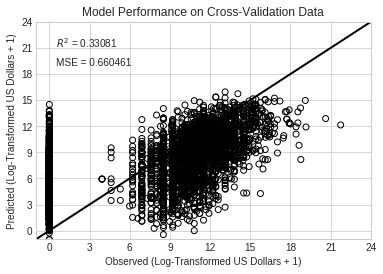

In [37]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [38]:
model.fc1.weight

Parameter containing:
-0.1525  0.0383  0.1660  0.3559  0.2680  0.0274  0.9514 -0.5033 -0.2284
-0.1762 -0.2313 -0.1681  0.0732  0.5366  0.5065  0.0901 -0.1476 -0.6617
-0.2016  0.1673  0.1134 -0.4478  0.5826  0.5403 -0.2284  0.1225 -0.0350
-0.0008  0.1534 -0.2352  0.1069  1.3911 -0.3269 -0.5405  0.0790 -0.0387
-0.1974  0.0163 -0.4641  0.1615  0.8492 -0.2606  0.6449 -0.0188 -0.3310
 0.0191  0.1869  0.1472  0.0132 -0.2165  0.3335 -0.0535  0.1631  0.3411
[torch.FloatTensor of size 6x9]

### 3.3 Store Predictions

In [39]:
add_to_stored("cv_pred_3", cv_predictors_Tensor, cv_stored)

add_to_stored("test_pred_3", test_predictors_Tensor, test_stored)

## 4. Four-Hidden-Layer Neural Network

In [40]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(9, 6)
        self.fc2 = torch.nn.Linear(6, 4)
        self.fc3 = torch.nn.Linear(4, 3)
        self.fc4 = torch.nn.Linear(3, 2)
        self.fc5 = torch.nn.Linear(2, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.relu(self.fc4(x))
        x = self.fc5(x)
        return(x)


# Make it
model = Net()

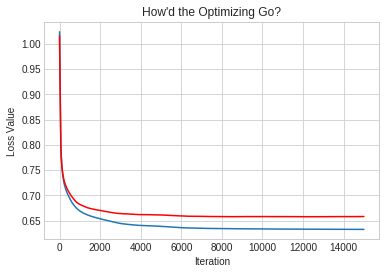

In [41]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

### 4.1 Performance Metrics

In [42]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 0.6582
[torch.FloatTensor of size 1]

In [43]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)
R_squared

Variable containing:
 0.3331
[torch.FloatTensor of size 1]

### 4.2 Performance Visualization

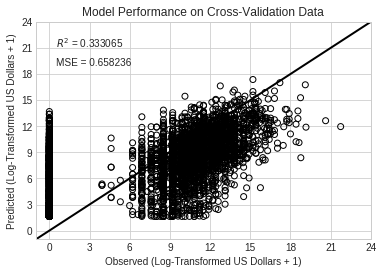

In [44]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [45]:
model.fc1.weight

Parameter containing:
-0.2020  0.2288 -0.3775 -0.4254  0.6306  0.2259  0.3020  0.3266 -0.3607
 0.1497  0.1503  0.1441 -0.3729  0.0678 -0.0736 -0.0127 -0.0121  0.5966
-0.0448  0.6423 -0.0744 -0.1582  0.2727 -0.8444 -0.0773  0.2254 -0.1802
-0.2445  0.7691 -0.0117 -0.0886 -0.1114  0.2052 -0.0094 -0.3117 -0.6259
-0.0342 -0.1931  0.4495 -0.0386 -0.9126  0.3455  0.8869 -0.0097 -0.2398
 0.0962 -0.4507 -0.0491 -0.1449 -0.2595  0.4714 -0.5328 -0.3545 -0.2532
[torch.FloatTensor of size 6x9]

### 4.3 Store Predictions

In [46]:
add_to_stored("cv_pred_4", cv_predictors_Tensor, cv_stored)

add_to_stored("test_pred_4", test_predictors_Tensor, test_stored)

## 5. Linear Regression

In [47]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(9, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        return(x)


# Make it
model = Net()

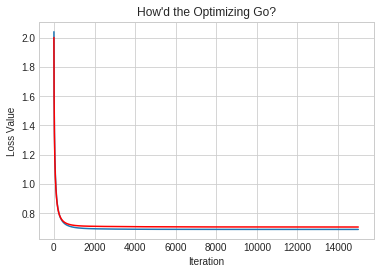

In [48]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

### 5.1 Performance Metrics

In [49]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 0.7066
[torch.FloatTensor of size 1]

In [50]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)
R_squared

Variable containing:
 0.2840
[torch.FloatTensor of size 1]

### 5.2 Performance Visualization

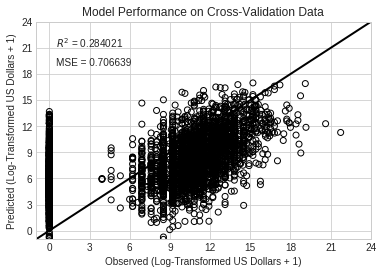

In [51]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [52]:
model.fc1.weight

Parameter containing:
 0.0089  0.1027  0.1471 -0.2532 -0.2212  0.2853 -0.1525  0.1395  0.0345
[torch.FloatTensor of size 1x9]

### 5.3 Store Predictions

In [53]:
add_to_stored("cv_pred_5", cv_predictors_Tensor, cv_stored)

add_to_stored("test_pred_5", test_predictors_Tensor, test_stored)

In [54]:
cv_stored.head()

,observed,cv_pred_1,cv_pred_2,cv_pred_3,cv_pred_4,cv_pred_5
0,0.677117,-0.041613,0.078235,0.091996,0.088559,-0.213414
1,0.484530,0.335433,0.315778,0.356760,0.370311,0.407347
2,0.058780,-0.459287,-0.579386,-0.468330,-0.736262,-0.309715
3,-1.421860,-0.221790,-0.207293,-0.388300,-0.704573,-0.041288
4,-1.421860,-0.768099,-0.942503,-1.082398,-0.965657,-0.711965


In [55]:
test_stored.head()

,observed,test_pred_1,test_pred_2,test_pred_3,test_pred_4,test_pred_5
0,0.356356,-0.791546,-0.968537,-0.834046,-0.924440,-0.549163
1,1.132974,0.547329,0.627409,0.591928,0.739936,0.707422
2,0.578992,-0.365639,-0.524888,-0.585166,-0.500452,-0.212378
3,-1.421860,1.091998,0.990639,1.107135,1.040510,1.037288
4,-1.421860,-0.744357,-0.848392,-0.724151,-0.715520,-0.555025


In [56]:
# Save the stored predictions and outcomes as a .csv
cv_stored.to_csv("13_cv_perf.csv")

test_stored.to_csv("13_test_perf.csv")